In [22]:
import numpy as np
import tensorflow as tf
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import TensorFlowV2Classifier
import matplotlib.pyplot as plt

In [23]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()


In [24]:
# Preprocess data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)


In [25]:
# Use a smaller subset of the dataset
subset_size = 1000  # Adjust this size as needed
x_test_subset = x_test[:subset_size]
y_test_subset = y_test[:subset_size]

In [26]:
# Create a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(100, activation="softmax")
])

In [27]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [28]:
# Train the model
model.fit(x_train, y_train, epochs=10, validation_split=0.1, batch_size=64)


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.0461 - loss: 4.2929 - val_accuracy: 0.1510 - val_loss: 3.6302
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.1772 - loss: 3.4307 - val_accuracy: 0.2228 - val_loss: 3.2135
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2562 - loss: 3.0342 - val_accuracy: 0.2502 - val_loss: 3.0577
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2970 - loss: 2.8121 - val_accuracy: 0.2930 - val_loss: 2.8384
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3292 - loss: 2.6330 - val_accuracy: 0.3158 - val_loss: 2.7438
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3615 - loss: 2.5053 - val_accuracy: 0.3250 - val_loss: 2.6884
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3855 - loss: 2.3767 - val_accuracy: 0.3354 - val_loss: 2.6393
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4117 - loss: 2.2707 - val_accuracy

In [29]:
# Define the loss function
loss_object = tf.keras.losses.CategoricalCrossentropy()


In [30]:
# Create ART classifier with loss function
classifier = TensorFlowV2Classifier(model=model, nb_classes=100, input_shape=(32, 32, 3), loss_object=loss_object)

In [31]:
# Initialize PGD attack
attack = ProjectedGradientDescent(estimator=classifier, eps=0.1, eps_step=0.01, max_iter=40)

In [32]:
# Iterate over a range of eps values
eps_values = np.linspace(0.01, 0.1, num=10)
accuracies = []

for eps in eps_values:
    # Update the attack with the current eps value
    attack.set_params(eps=eps)

    # Generate adversarial examples
    x_adv = attack.generate(x=x_test_subset)

    # Evaluate model accuracy on adversarial examples
    accuracy = np.mean(np.argmax(classifier.predict(x_adv), axis=1) == np.argmax(y_test_subset, axis=1))
    accuracies.append(accuracy)

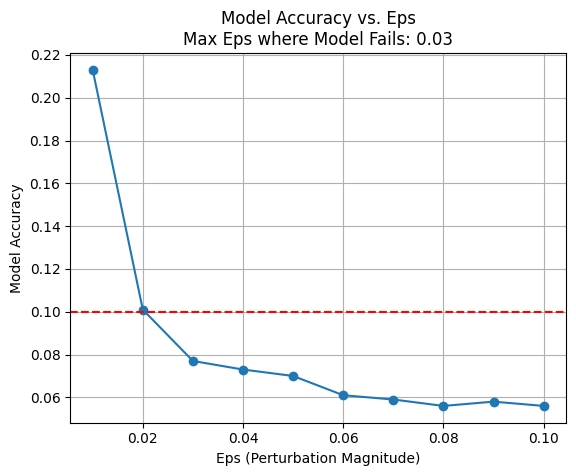

Maximum eps value after which the model fails (accuracy <= 10%): 0.03


In [33]:
# Identify the maximum eps value where accuracy drops below 10%
threshold_accuracy = 0.1
max_eps_fail = eps_values[np.where(np.array(accuracies) <= threshold_accuracy)[0][0]]

# Plot the graph
plt.plot(eps_values, accuracies, marker="o")
plt.axhline(y=threshold_accuracy, color='r', linestyle='--')
plt.xlabel("Eps (Perturbation Magnitude)")
plt.ylabel("Model Accuracy")
plt.title(f"Model Accuracy vs. Eps\nMax Eps where Model Fails: {max_eps_fail:.2f}")
plt.grid(True)
plt.show()

print(f"Maximum eps value after which the model fails (accuracy <= 10%): {max_eps_fail:.2f}")